In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
pd.set_option('display.max_rows', 150)


In [40]:
# folder_path = "C:/Topics Data/Usage Data"  # e.g. "data/"
# csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# csv_files  # optional: see which files are picked up

In [41]:
# df_list = [pd.read_csv(f) for f in csv_files]

# combined = pd.concat(df_list, ignore_index=True)

In [42]:
# combined.to_csv("combined.csv", index=False)


In [43]:
# df1 = pd.read_csv("combined.csv")
# df1.head()

In [44]:
# for f in csv_files:
#     df = pd.read_csv(f)
#     print(os.path.basename(f), df.shape)

In [45]:
# df1.shape

In [46]:
# total_rows = 0

# for f in csv_files:
#     df = pd.read_csv(f)
#     total_rows += df.shape[0]

# print("Total rows across all files:", total_rows)

In [47]:
# # Adjust this pattern to match where your CSVs are stored
# files = glob("combined.csv")

# df_list = []
# for f in files:
#     tmp = pd.read_csv(
#         f,
#         parse_dates=['Start date', 'End date']  # adapt column names if needed
#     )
#     df_list.append(tmp)

# df = pd.concat(df_list, ignore_index=True)
# print(df.head())
# print(df.shape)


In [48]:
df = pd.read_csv("combined.csv")

# Convert to proper datetimes
df['Start date'] = pd.to_datetime(df['Start date'], format="%Y-%m-%d %H:%M", errors='coerce')
df['End date']   = pd.to_datetime(df['End date'],   format="%Y-%m-%d %H:%M", errors='coerce')

# (Optional) drop rows where conversion failed
df = df.dropna(subset=['Start date', 'End date'])


In [49]:
# Duration in minutes
df['duration_min'] = df['Total duration (ms)'] / 60000.0  # ms → minutes

# Remove impossible / extreme journeys
df = df[(df['duration_min'] >= 1) & (df['duration_min'] <= 120)]

# Drop rows with missing key fields
df = df.dropna(subset=['Start date', 'End date'])

# Basic datetime features
df['date'] = df['Start date'].dt.date
df['hour'] = df['Start date'].dt.hour
df['day_of_week'] = df['Start date'].dt.dayofweek  # 0=Mon, 6=Sun
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
df['month'] = df['Start date'].dt.month

# Optional: simple day index from the start of 2024
df = df[df['Start date'].dt.date >= pd.to_datetime('2024-01-01').date()]
df = df[df['Start date'].dt.date <= pd.to_datetime('2025-05-31').date()]

df['day_index'] = (df['Start date'].dt.normalize() - pd.Timestamp('2024-01-01')) \
                    .dt.days
print(df.head())

      Number          Start date  Start station number  \
0  136666627 2024-01-14 23:59:00                  1108   
1  136666625 2024-01-14 23:57:00                  3447   
2  136666626 2024-01-14 23:57:00                  1090   
3  136666622 2024-01-14 23:56:00                200058   
4  136666623 2024-01-14 23:56:00                  1052   

                         Start station            End date  \
0         North Wharf Road, Paddington 2024-01-15 00:06:00   
1  Gloucester Road (North), Kensington 2024-01-15 00:05:00   
2        Warren Street Station, Euston 2024-01-15 00:02:00   
3       Northdown Street, King's Cross 2024-01-15 00:06:00   
4                   Soho Square , Soho 2024-01-15 00:23:00   

   End station number                          End station  Bike number  \
0                3423               Maida Vale, Maida Vale      53020.0   
1                1214  Kensington Olympia Station, Olympia      54559.0   
2              200005     New Cavendish Street, Maryl

In [50]:
hourly = (
    df
    .groupby(['date', 'hour'], as_index=False)
    .agg(
        trip_count=('Bike number', 'count'),      # counts of journeys
        mean_duration=('duration_min', 'mean'),
        day_of_week=('day_of_week', 'first'),
        is_weekend=('is_weekend', 'first'),
        month=('month', 'first'),
        day_index=('day_index', 'first')
    )
)

hourly.head()


,date,hour,trip_count,mean_duration,day_of_week,is_weekend,month,day_index
0,2024-01-01,0,735,29.399435,0,0,1,0
1,2024-01-01,1,955,27.300924,0,0,1,0
2,2024-01-01,2,514,21.800756,0,0,1,0
3,2024-01-01,3,267,19.087863,0,0,1,0
4,2024-01-01,4,194,20.805400,0,0,1,0


In [51]:
# Features and target
feature_cols = ['hour', 'day_of_week', 'is_weekend', 'month', 'day_index']
X = hourly[feature_cols].copy()
y = hourly['trip_count'].copy()

# One-hot encode categorical features
X = pd.get_dummies(
    X,
    columns=['hour', 'day_of_week', 'month'],
    drop_first=True  # avoid dummy variable trap
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

X_train.shape, X_test.shape


((8751, 40), (2188, 40))

In [52]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)

mse  = mean_squared_error(y_test, y_pred)  # no squared=
rmse = np.sqrt(mse)

mae = mean_absolute_error(y_test, y_pred)

print(f"R^2:  {r2:.3f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")


R^2:  0.703
RMSE: 452.52
MAE:  312.94


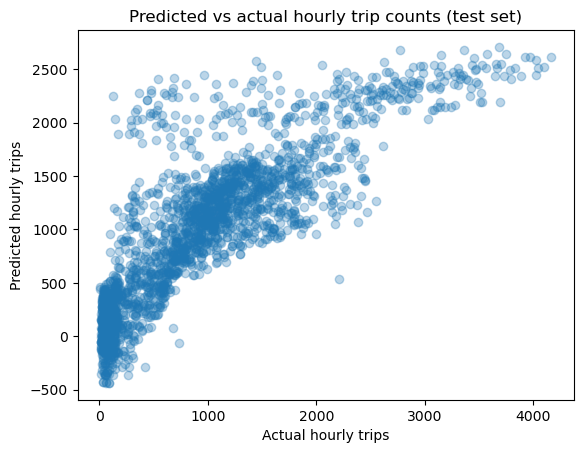

In [53]:
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual hourly trips")
plt.ylabel("Predicted hourly trips")
plt.title("Predicted vs actual hourly trip counts (test set)")
plt.show()


In [ ]:
# # Build a small design table for a hypothetical scenario:
# scenario = pd.DataFrame({
#     'hour': np.arange(24),
#     'day_of_week': [2]*24,   # 2 = Wednesday
#     'is_weekend': [0]*24,
#     'month': [3]*24,         # March
#     'day_index': [60]*24     # ~early March (rough; just for example)
# })

# scenario_X = pd.get_dummies(
#     scenario,
#     columns=['hour', 'day_of_week', 'month'],
#     drop_first=True
# )

# # Align columns with training data (add missing dummy cols as 0)
# for col in X_train.columns:
#     if col not in scenario_X.columns:
#         scenario_X[col] = 0

# scenario_X = scenario_X[X_train.columns]  # same column order

# scenario['predicted_trips_london'] = model.predict(scenario_X)
# print(scenario[['hour', 'predicted_trips_london']])


    hour  predicted_trips_london
0      0              -51.532234
1      1             -126.538621
2      2             -158.321949
3      3             -203.230569
4      4             -193.921248
5      5             -123.145155
6      6              206.918177
7      7              946.456058
8      8             2045.593282
9      9             1203.824255
10    10              813.413449
11    11              821.596421
12    12             1002.626988
13    13              997.254242
14    14              952.939946
15    15             1054.247784
16    16             1343.735108
17    17             2085.358280
18    18             1919.622694
19    19             1184.576336
20    20              709.004201
21    21              436.738257
22    22              309.574757
23    23               98.164869


In [ ]:
# # Example placeholder values – replace with actual figures you use in the report
# LONDON_POP =  9_089_736   # population in catchment area used for per-capita scaling
# EXETER_POP =  138_399      # population in Exeter scheme catchment
# SCALE_FACTOR = 0.5       # density/tourism adjustment

# # Convert London predictions to per 1,000 residents
# scenario['pred_per_1000_london'] = scenario['predicted_trips_london'] / (LONDON_POP / 1000)

# # Apply scaling factor to get Exeter per 1,000
# scenario['pred_per_1000_exeter'] = scenario['pred_per_1000_london'] * SCALE_FACTOR

# # Convert to total hourly trips for Exeter
# scenario['predicted_trips_exeter'] = scenario['pred_per_1000_exeter'] * (EXETER_POP / 1000)

# print(scenario[['hour',
#                 'predicted_trips_london',
#                 'predicted_trips_exeter']])


    hour  predicted_trips_london  predicted_trips_exeter
0      0              -51.532234               -0.392311
1      1             -126.538621               -0.963329
2      2             -158.321949               -1.205293
3      3             -203.230569               -1.547180
4      4             -193.921248               -1.476308
5      5             -123.145155               -0.937495
6      6              206.918177                1.575253
7      7              946.456058                7.205301
8      8             2045.593282               15.572953
9      9             1203.824255                9.164627
10    10              813.413449                6.192458
11    11              821.596421                6.254754
12    12             1002.626988                7.632926
13    13              997.254242                7.592024
14    14              952.939946                7.254663
15    15             1054.247784                8.025912
16    16             1343.73510

In [56]:
mask = (df['Start date'] >= "2025-01-01") & (df['Start date'] <= "2025-05-31")
df_period = df.loc[mask]

top5_start = df_period['Start station'].value_counts().head(5)
print(top5_start)
print()
top5_end = df['End station'].value_counts().head(5)
print(top5_end)
print()
start_counts = df['Start station'].value_counts()
end_counts   = df['End station'].value_counts()

total_counts = start_counts.add(end_counts, fill_value=0)
top5_total   = total_counts.sort_values(ascending=False).head(5)

print(top5_total)


Start station
Hyde Park Corner, Hyde Park          22113
Waterloo Station 3, Waterloo         19620
Waterloo Station 1, Waterloo         18467
Wormwood Street, Liverpool Street    16398
Argyle Street, Kings Cross           14869
Name: count, dtype: int64

End station
Hyde Park Corner, Hyde Park            66273
Waterloo Station 3, Waterloo           63945
Waterloo Station 1, Waterloo           52398
Hop Exchange, The Borough              51953
Brushfield Street, Liverpool Street    50270
Name: count, dtype: int64

Hyde Park Corner, Hyde Park          135665
Waterloo Station 3, Waterloo         124410
Waterloo Station 1, Waterloo         105431
Wormwood Street, Liverpool Street     95922
Hop Exchange, The Borough             92608
Name: count, dtype: int64


In [57]:
# 1) Build X_full for all rows in 'hourly'
feature_cols = ['hour', 'day_of_week', 'is_weekend', 'month', 'day_index']

X_full = hourly[feature_cols].copy()

X_full = pd.get_dummies(
    X_full,
    columns=['hour', 'day_of_week', 'month'],
    drop_first=True
)

# 2) Align columns with training data
for col in X_train.columns:
    if col not in X_full.columns:
        X_full[col] = 0

X_full = X_full[X_train.columns]   # same column order as in training


In [58]:
hourly['predicted_trips_london'] = model.predict(X_full)

# Clip tiny negative values to zero
hourly['predicted_trips_london'] = hourly['predicted_trips_london'].clip(lower=0)


In [59]:
LONDON_POP = 8_776_535   # whatever you chose
EXETER_POP = 130_700
SCALE_FACTOR = 0.5

hourly['pred_per_1000_london'] = hourly['predicted_trips_london'] / (LONDON_POP / 1000)
hourly['pred_per_1000_exeter'] = hourly['pred_per_1000_london'] * SCALE_FACTOR
hourly['predicted_trips_exeter'] = hourly['pred_per_1000_exeter'] * (EXETER_POP / 1000)

hourly['predicted_trips_exeter'] = hourly['predicted_trips_exeter'].clip(lower=0)


In [60]:
daily_pred = (
    hourly
    .groupby('date', as_index=False)
    .agg(
        trips_london=('predicted_trips_london', 'sum'),
        trips_exeter=('predicted_trips_exeter', 'sum')
    )
)

print(daily_pred.head())


         date  trips_london  trips_exeter
0  2024-01-01  17897.569916    133.265143
1  2024-01-02  19344.467256    144.038728
2  2024-01-03  20382.217700    151.765808
3  2024-01-04  19915.197233    148.288378
4  2024-01-05  17738.179557    132.078324


In [61]:
def month_to_season(m):
    if m in [12, 1, 2]:
        return 'Winter'
    elif m in [3, 4, 5]:
        return 'Spring'
    elif m in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

hourly['season'] = hourly['month'].apply(month_to_season)


In [62]:
season_profile = (
    hourly
    .groupby(['season', 'hour'], as_index=False)
    .agg(
        trips_london=('predicted_trips_london', 'mean'),
        trips_exeter=('predicted_trips_exeter', 'mean')
    )
)

print(season_profile.head())


   season  hour  trips_london  trips_exeter
0  Autumn     0    279.503700      2.081182
1  Autumn     1    209.415765      1.559308
2  Autumn     2    180.311405      1.342597
3  Autumn     3    144.365966      1.074948
4  Autumn     4    151.691333      1.129492


In [73]:
# --- 1. Build a "template" week: Monday–Sunday, hours 0–23 ---

day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday',
             'Friday', 'Saturday', 'Sunday']

day_codes = {
    'Monday': 0,
    'Tuesday': 1,
    'Wednesday': 2,
    'Thursday': 3,
    'Friday': 4,
    'Saturday': 5,
    'Sunday': 6
}

rows = []
for day in day_names:
    dow = day_codes[day]
    is_weekend = 1 if dow >= 5 else 0
    for h in range(24):
        rows.append({
            'day_name': day,
            'hour': h,
            'day_of_week': dow,
            'is_weekend': is_weekend,
            # choose a representative month & day_index
            'month': 3,       # March as example
            'day_index': 60   # ~early March, just a placeholder trend value
        })

week_df = pd.DataFrame(rows)

# --- 2. Create features exactly like training (dummies) ---

feature_cols = ['hour', 'day_of_week', 'is_weekend', 'month', 'day_index']

X_week = week_df[feature_cols].copy()

X_week = pd.get_dummies(
    X_week,
    columns=['hour', 'day_of_week', 'month'],
    drop_first=True
)

# Align dummy columns with X_train
for col in X_train.columns:
    if col not in X_week.columns:
        X_week[col] = 0

X_week = X_week[X_train.columns]   # same column order

# --- 3. Predict London hourly demand for this template week ---

week_df['result_london'] = model.predict(X_week)
week_df['result_london'] = week_df['result_london'].clip(lower=0)

# --- 4. Scale to Exeter ---

LONDON_POP = 8_776_535   # your chosen London population
EXETER_POP = 130_700     # your chosen Exeter population
SCALE_FACTOR = 0.5       # your scaling factor

week_df['pred_per_1000_london'] = week_df['result_london'] / (LONDON_POP / 1000)
week_df['pred_per_1000_exeter'] = week_df['pred_per_1000_london'] * SCALE_FACTOR
week_df['result_exeter']        = week_df['pred_per_1000_exeter'] * (EXETER_POP / 1000)

week_df['result_exeter'] = week_df['result_exeter'].clip(lower=0)

# --- 5. Sort nicely and show final structure ---

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday',
             'Friday', 'Saturday', 'Sunday']

week_df['day_name'] = pd.Categorical(week_df['day_name'],
                                     categories=day_order,
                                     ordered=True)

week_df = week_df.sort_values(['day_name', 'hour'])

# Only keep the columns you care about:
result_table = week_df[['day_name', 'hour', 'result_london', 'result_exeter']]

pd.set_option('display.max_rows', None)
print(result_table.head(168))      # Monday 0–19
# print(result_table.tail(10))      # end of Sunday


      day_name  hour  result_london  result_exeter
0       Monday     0       0.000000       0.000000
1       Monday     1       0.000000       0.000000
2       Monday     2       0.000000       0.000000
3       Monday     3       0.000000       0.000000
4       Monday     4       0.000000       0.000000
5       Monday     5       0.000000       0.000000
6       Monday     6     206.918177       1.540711
7       Monday     7     946.456058       7.047303
8       Monday     8    2045.593282      15.231469
9       Monday     9    1203.824255       8.963664
10      Monday    10     813.413449       6.056669
11      Monday    11     821.596421       6.117599
12      Monday    12    1002.626988       7.465551
13      Monday    13     997.254242       7.425546
14      Monday    14     952.939946       7.095582
15      Monday    15    1054.247784       7.849919
16      Monday    16    1343.735108      10.005439
17      Monday    17    2085.358280      15.527559
18      Monday    18    1919.62

In [74]:
def month_to_season(m):
    if m in [12, 1, 2]:
        return 'Winter'
    elif m in [3, 4, 5]:
        return 'Spring'
    elif m in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

hourly['season'] = hourly['month'].apply(month_to_season)


In [75]:
season_totals = (
    hourly
    .groupby('season', as_index=False)
    .agg(
        total_london=('predicted_trips_london', 'sum'),
        total_exeter=('predicted_trips_exeter', 'sum')
    )
)

# Optional: order the seasons nicely
season_order = ['Winter', 'Spring', 'Summer', 'Autumn']
season_totals['season'] = pd.Categorical(
    season_totals['season'],
    categories=season_order,
    ordered=True
)
season_totals = season_totals.sort_values('season')

print(season_totals)


   season  total_london  total_exeter
3  Winter  2.871328e+06  21379.883969
1  Spring  4.515806e+06  33624.651698
2  Summer  1.731595e+06  12893.441436
0  Autumn  1.540993e+06  11474.218255
